# Search images with deep learning

Images are usually very different if we compare them at pixel level but that's quite different if we look at them after they were processed by a deep learning model. We convert each image into a feature vector extracted from an intermediate layer of the network.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Get a pre-trained model

We choose the model described in paper [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861). Pre-trained models are available at [deep-learning-models/releases](https://github.com/fchollet/deep-learning-models/releases/).

In [3]:
from keras.applications.mobilenet import MobileNet
model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, 
                  weights='imagenet', input_tensor=None, pooling=None, classes=1000)
model

Using TensorFlow backend.


In [4]:
model.name

'mobilenet_1.00_224'

The model is stored here:

In [5]:
import os
os.listdir(os.path.join(os.environ['USERPROFILE'], ".keras", "models"))

['mobilenet_1_0_224_tf.h5']

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

## Images

We collect images from [pixabay](https://pixabay.com/).

### Raw images

In [7]:
from pyquickhelper.filehelper import unzip_files
if not os.path.exists('simages'):
    os.mkdir('simages')
files = unzip_files("data/dog-cat-pixabay.zip", where_to="simages")
len(files), files[0]

(31, 'simages\\cat-1151519__480.jpg')

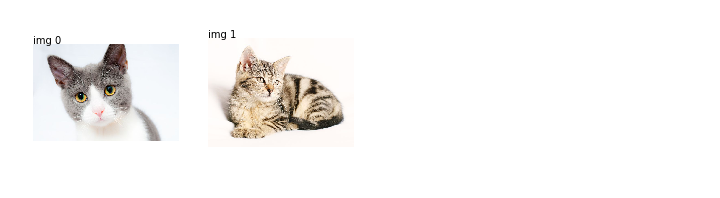

In [8]:
from mlinsights.plotting import plot_gallery_images            
plot_gallery_images(files[:2]);

In [9]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
img = load_img('simages/cat-2603300__480.jpg')
x = img_to_array(img)
x.shape

(480, 320, 3)

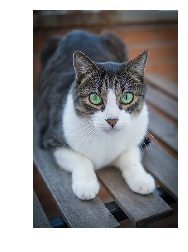

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x / 255)
plt.axis('off');

[keras](https://keras.io/) implements optimized function to load and process images. Below the code with loads the images without modifying them. It creates an iterator which iterates as many times as we want.

In [11]:
params = dict(rescale=1./255)

I suggest trying without the parameter *rescale* to see the differences. The neural network expects numbers in ``[0, 1]`` not in ``[0, 255]``.

In [12]:
from keras.preprocessing.image import ImageDataGenerator
import numpy
augmenting_datagen = ImageDataGenerator(**params)
# zip(range(0,2)) means to stop the loop after 2 iterations
imgs = list(img[0] for i, img in zip(range(0,2), augmenting_datagen.flow(x[numpy.newaxis, :, :, :])))
len(imgs), imgs[0].shape

(2, (480, 320, 3))

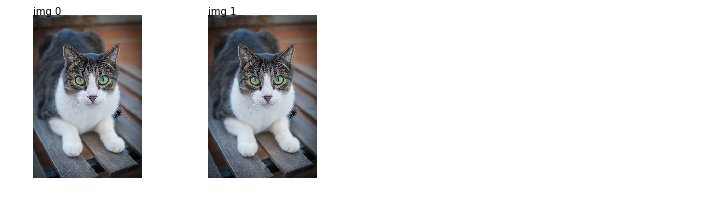

In [13]:
plot_gallery_images(imgs);

But you can multiply the images. See [ImageDataGenerator](https://keras.io/preprocessing/image/) parameters to see what kind of modifications is implemented.

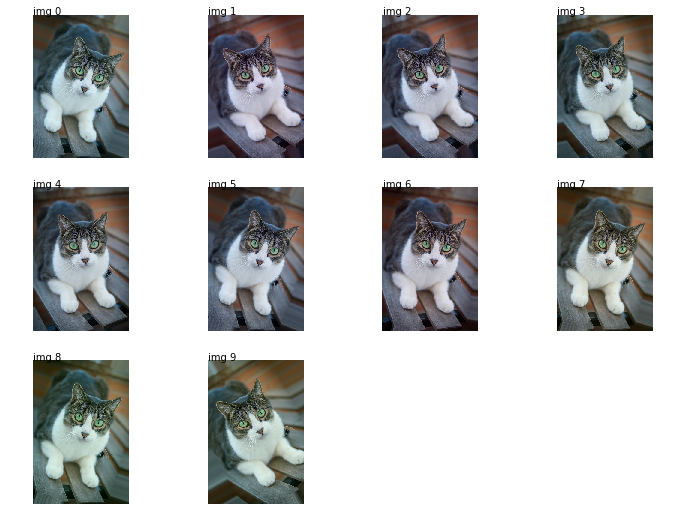

In [14]:
augmenting_datagen_2 = ImageDataGenerator(rotation_range=40, channel_shift_range=9, **params)
imgs = list(img[0] for i, img in zip(range(0,10), augmenting_datagen_2.flow(x[numpy.newaxis, :, :, :])))
plot_gallery_images(imgs);

### Iterator on images

We create an iterator, it considers every subfolders of images. We also need to rescale to size *(224, 224)* which is the size the loaded neural network ingests.

In [15]:
flow = augmenting_datagen.flow_from_directory('.', batch_size=1, target_size=(224, 224), classes=['simages'])
imgs = list(img[0][0] for i, img in zip(range(0,10), flow))
len(imgs), imgs[0].shape, type(flow)

Found 31 images belonging to 1 classes.


(10, (224, 224, 3), keras.preprocessing.image.DirectoryIterator)

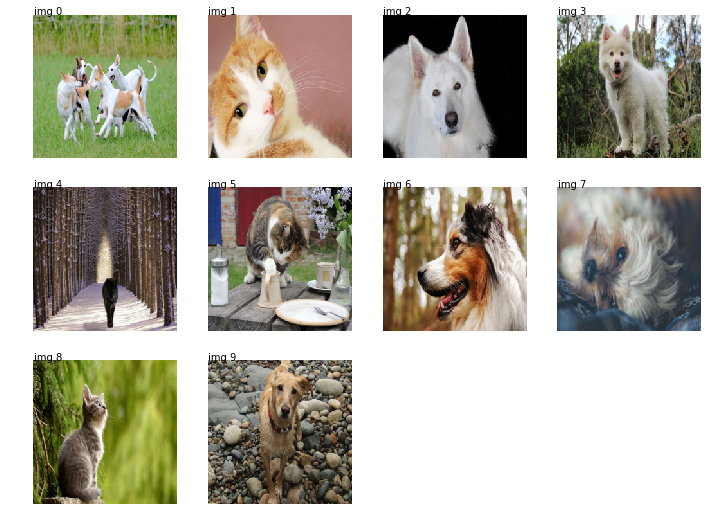

In [16]:
plot_gallery_images(imgs);

How to get the image name?

In [17]:
def get_current_index(flow):
    # The iterator is one step ahead.
    return (flow.batch_index + flow.n - 1) % flow.n

flow = augmenting_datagen.flow_from_directory('.', batch_size=1, target_size=(224, 224), 
                                              classes=['simages'], shuffle=False)
imgs = list((img[0][0], get_current_index(flow), flow.index_array[get_current_index(flow)], 
             flow.filenames[get_current_index(flow)]) for i, img in zip(range(0,31), flow))
imgs[0][1:]

Found 31 images belonging to 1 classes.


(0, 0, 'simages\\cat-1151519__480.jpg')

In [18]:
imgs[-1][1:]

(30, 30, 'simages\\wolf-2865653__480.jpg')

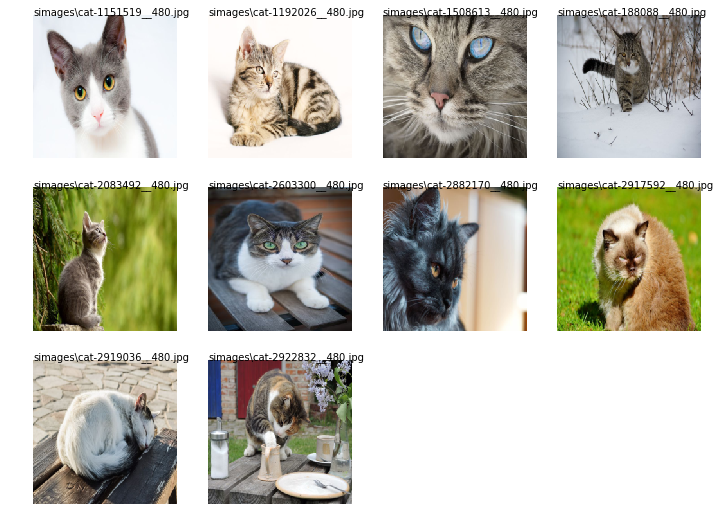

In [19]:
imgs = list((img[0][0], flow.filenames[get_current_index(flow)]) for i, img in zip(range(0,10), flow))
plot_gallery_images([_[0] for _ in imgs], [_[1] for _ in imgs]);

To keep the original order.

Found 31 images belonging to 1 classes.


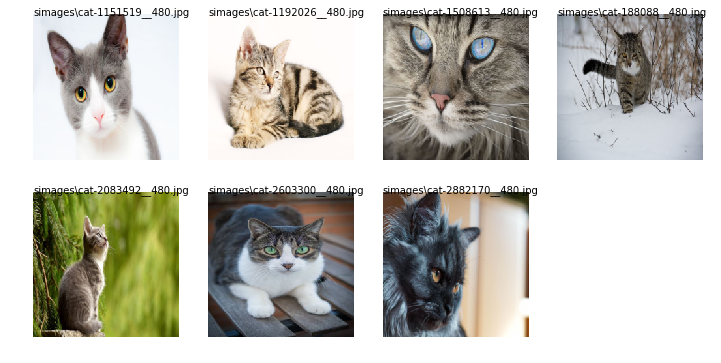

In [20]:
flow = augmenting_datagen.flow_from_directory('.', batch_size=1, target_size=(224, 224), shuffle=False,
                                              classes=['simages'])
imgs = list((img[0][0], flow.filenames[get_current_index(flow)]) for i, img in zip(range(0,7), flow))
plot_gallery_images([_[0] for _ in imgs], [_[1] for _ in imgs]);

In [21]:
len(flow)

31

## Search among images

We use the class ``SearchEnginePredictionImages``.

### Using one intermediate layer close to the output

In [22]:
model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, 
                  weights='imagenet', input_tensor=None, pooling=None, classes=1000)
model

In [23]:
gen = ImageDataGenerator(rescale=1./255)
iterimf = gen.flow_from_directory(".", batch_size=1, target_size=(224, 224),
                                 classes=['simages'], shuffle=False)

Found 31 images belonging to 1 classes.


In [24]:
from mlinsights.search_rank import SearchEnginePredictionImages
se = SearchEnginePredictionImages(model, fct_params=dict(layer=len(model.layers) - 2), 
                                  n_neighbors=5)

In [25]:
se.fit(iterimf)
se.features_.shape

(31, 1000)

In [26]:
se.features_.shape

(31, 1000)

In [27]:
list(se.metadata_)[:5]

['simages\\cat-1151519__480.jpg',
 'simages\\cat-1192026__480.jpg',
 'simages\\cat-1508613__480.jpg',
 'simages\\cat-188088__480.jpg',
 'simages\\cat-2083492__480.jpg']

In [28]:
se.metadata_.shape

(31,)

Let's choose one image.

In [29]:
name = se.metadata_[5]
name

'simages\\cat-2603300__480.jpg'

In [30]:
img = load_img(name, target_size=(224, 224))
x = img_to_array(img)

In [31]:
gen = ImageDataGenerator(rescale=1./255)
iterim = gen.flow(x[numpy.newaxis, :, :, :], batch_size=1)

In [32]:
score, ind, meta = se.kneighbors(iterim)

In [33]:
score, ind, meta

(array([ 0.        ,  0.09024489,  0.09526572,  0.14164217,  0.24973566]),
 array([ 5, 28, 11,  1,  2], dtype=int64),
 array(['simages\\cat-2603300__480.jpg',
        'simages\\shotlanskogo-2934720__480.jpg',
        'simages\\cat-2946028__480.jpg', 'simages\\cat-1192026__480.jpg',
        'simages\\cat-1508613__480.jpg'],
       dtype='<U37'))

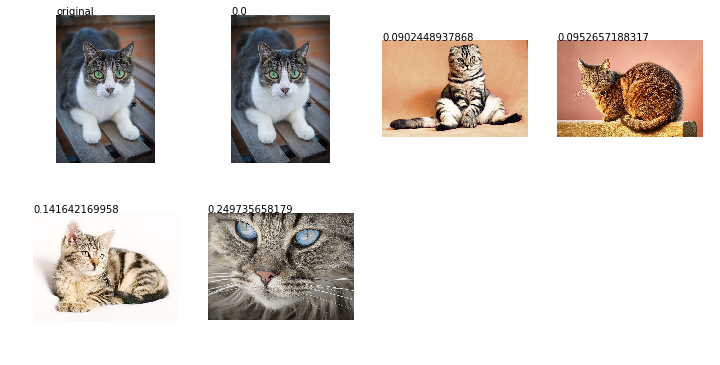

In [34]:
texts = ['original'] + [str(_) for _ in score]
imgs = [name] + list(meta)
plot_gallery_images(imgs, texts);

### Using one intermediate layer close to the input

In [35]:
se = SearchEnginePredictionImages(model, fct_params=dict(layer=1), n_neighbors=5)
se.fit(iterimf)
se.features_.shape

(31, 401408)

In [36]:
iterim = gen.flow(x[numpy.newaxis, :, :, :], batch_size=1)
score, ind, meta = se.kneighbors(iterim)

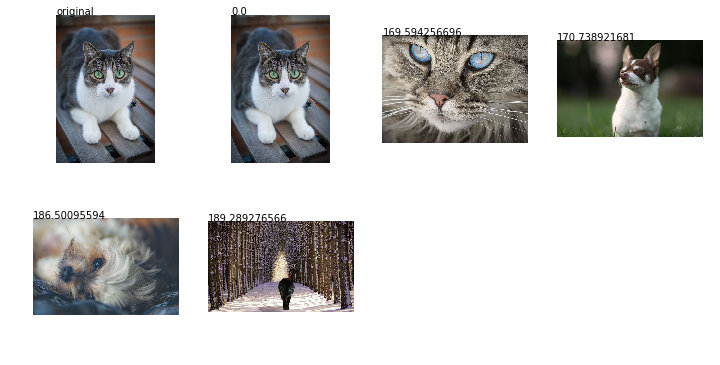

In [37]:
texts = ['original'] + [str(_) for _ in score]
imgs = [name] + list(meta)
plot_gallery_images(imgs, texts);

This is worse.